# images of graphy subjects

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.rcParams['figure.figsize'] = (20, 20)

import itertools
import re

import pandas as pd
import numpy as np
import networkx as nx

from sklearn.cluster import AgglomerativeClustering

from umap import UMAP
from tqdm import tqdm_notebook as tqdm

In [2]:
def flatten(input_list):
    return [item 
            for sublist in input_list 
            for item in sublist]

def clean(subject):
    return subject.strip().lower().replace('<p>', '')

In [3]:
df = pd.read_json('data/calm_records.json')

In [4]:
df['AltRefNo'] = df['AltRefNo'].dropna().apply(lambda x: x[0])
df['Subject'] = df['Subject'].dropna().apply(lambda x: list(map(clean, x)))

In [5]:
dirty_subjects = flatten(df['Subject'].dropna().tolist())
subjects = list(set(map(clean, dirty_subjects)))

In [7]:
adjacency = pd.DataFrame(data=0, 
                         index=subjects, 
                         columns=subjects)

In [8]:
for row_of_subjects in tqdm(df['Subject'].dropna()):
    
    clean_row = list(set([clean(subject) for subject in row_of_subjects]))
    
    for subject_1, subject_2 in itertools.product(clean_row, repeat=2):
        adjacency[subject_1][subject_2] += 1

HBox(children=(IntProgress(value=0, max=16664), HTML(value='')))

In [ ]:
G = nx.from_pandas_adjacency(adjacency)
nx.draw_spring(G, node_size=60)

### quite complicated
lets get rid of the rare subjects and only look at common ones

subject_counts = pd.Series(map(clean, dirty_subjects)).value_counts() 
rare_subjects = subject_counts[subject_counts < 10].index.values

len(subjects) - len(rare_subjects) 

mini_adjacency = (adjacency
                  .drop(rare_subjects, axis=0)
                  .drop(rare_subjects, axis=1))

In [ ]:
mini_adjacency = adjacency.mask(mini_adjacency < 10, 0)
mini_adjacency

In [ ]:
G = nx.from_pandas_adjacency(mini_adjacency)

nx.draw_spring(G, node_size=60)

lots of orphans... lets get rid of those

In [ ]:
orphans = [subject for subject in mini_adjacency.index.values
           if mini_adjacency[subject].sum() == mini_adjacency[subject][subject]]

mini_adjacency = (adjacency
                  .drop(orphans, axis=0)
                  .drop(orphans, axis=1))

In [ ]:
G = nx.from_pandas_adjacency(mini_adjacency)

nx.draw(G, node_size=60)

### now clustering

In [ ]:
embedding_2d = pd.DataFrame(UMAP(n_components=2)
                            .fit_transform(mini_adjacency))

In [ ]:
n_clusters = 15

embedding_2d['labels'] = (AgglomerativeClustering(n_clusters)
                          .fit_predict(embedding_2d.values))

In [ ]:
nx.draw_spring(G, node_size=40, 
               node_color=embedding_2d['labels'],
               alpha=0.1)

this thing is a real mess - subjects behave weirdly, and seem to either be weirdo one-offs, or super connected to everything. Still we can extract little structures and clusters. It's fine. Let's start using them.

# connect records by subject

In [11]:
with_subjects = df[~df['Subject'].isna()].set_index('AltRefNo').sample(1000)

In [12]:
indicies = np.nan_to_num(with_subjects.index.values).astype(str)

In [13]:
with_subjects.index = indicies

In [14]:
adjacency = pd.DataFrame(data=0,
                         index=indicies,
                         columns=indicies)

In [15]:
for record_1, record_2 in tqdm(list(itertools.combinations(indicies, r=2))):
    subjects_1 = set(with_subjects['Subject'][record_1])
    subjects_2 = set(with_subjects['Subject'][record_2])
    adjacency[record_1][record_2] = len(subjects_1 & subjects_2)

HBox(children=(IntProgress(value=0, max=499500), HTML(value='')))

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/pimharr/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/pimharr/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/pimharr/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [16]:
orphans = [record for record in adjacency.index.values
           if adjacency[record].sum() == adjacency[record][record]]

adjacency = (adjacency
             .drop(orphans, axis=0)
             .drop(orphans, axis=1))

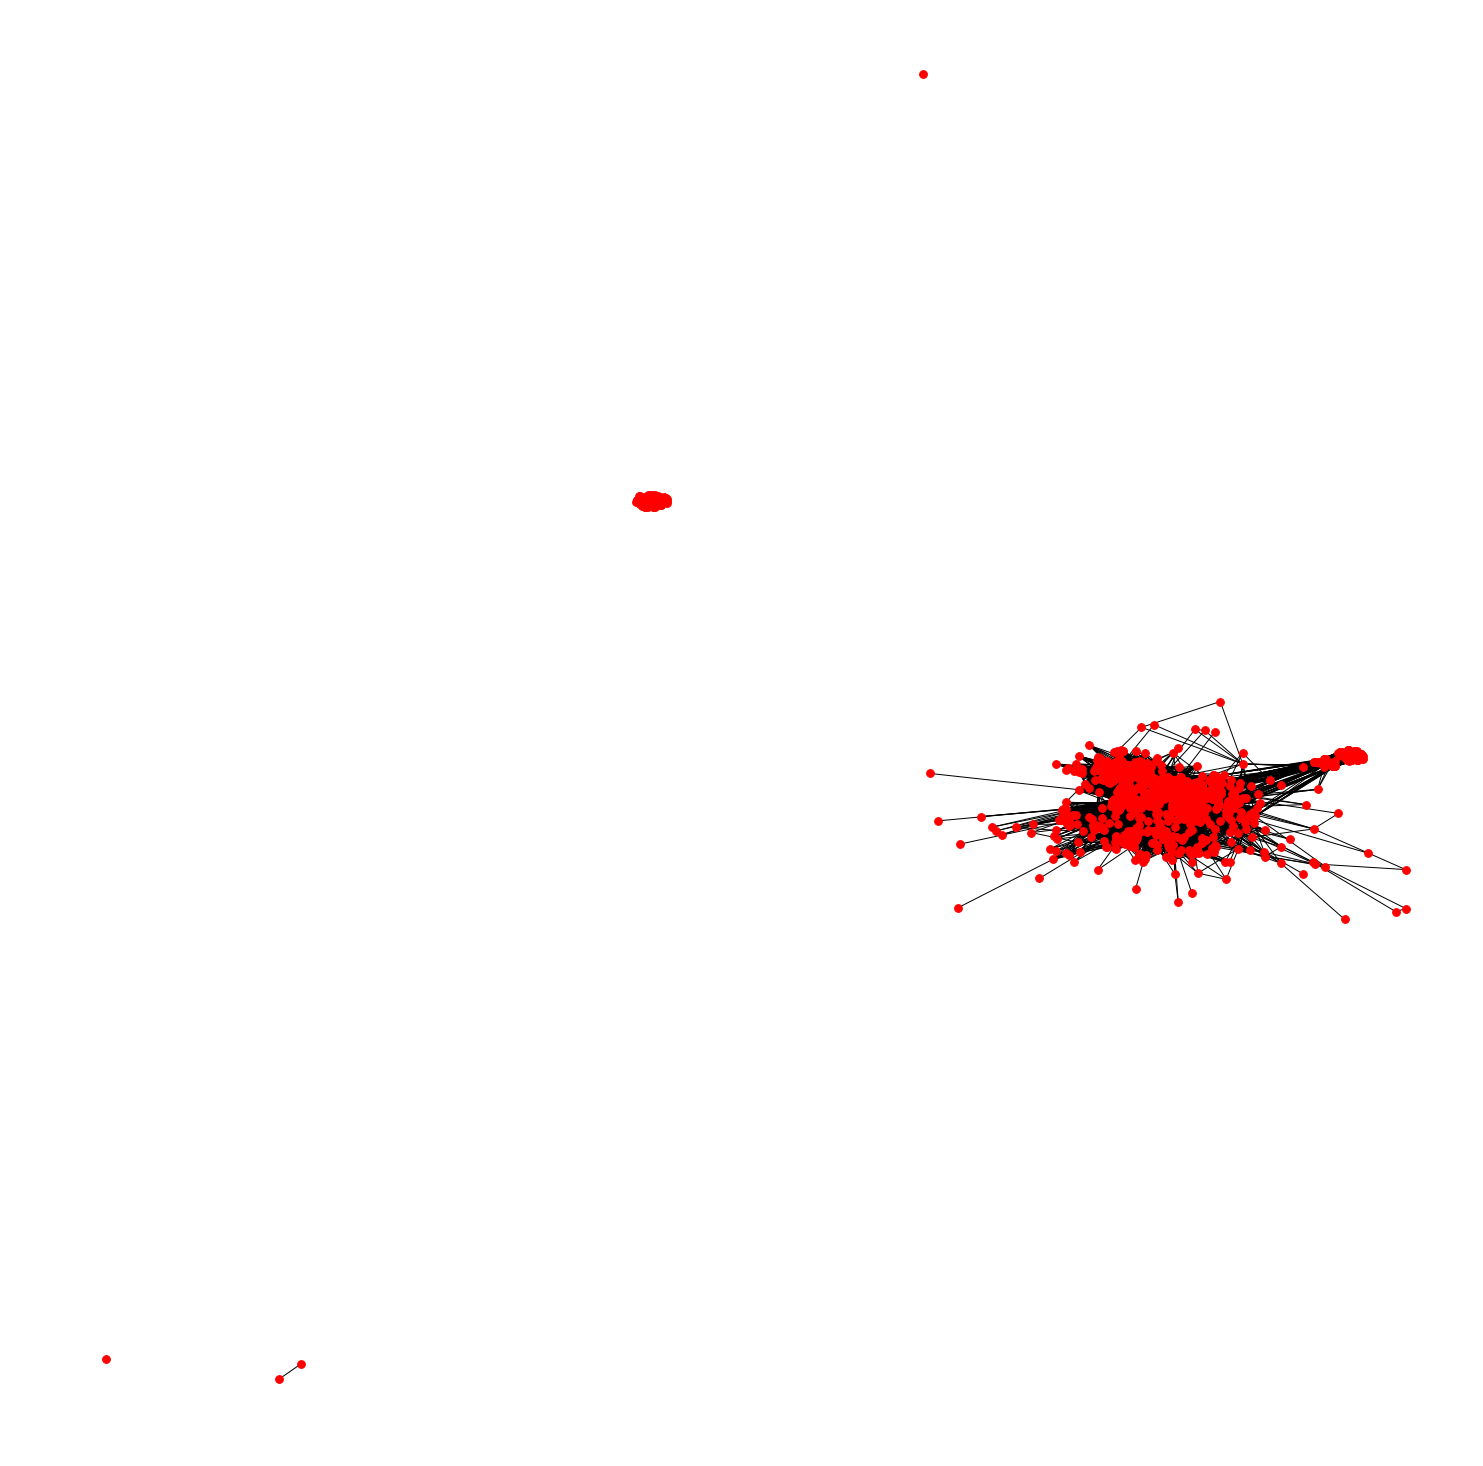

In [22]:
G = nx.from_pandas_adjacency(adjacency)

nx.draw(G, node_size=60)

In [26]:
subjects

['',
 'hypersplenism',
 'rosicrucians',
 'acquired immunodeficiency syndrome',
 'calcium chloride',
 'slavery',
 'employment references',
 'deglutition disorders',
 'sulfates',
 'disabled persons',
 'infant welfare',
 'arrhythmia',
 'ceramic tableware',
 'medical sciences',
 'halitosis',
 'volcanoes',
 'emetine',
 'retina',
 'animals',
 'jaw',
 'camphor',
 'life cycle stages',
 'paleopathology',
 'diarrhea',
 'military campaigns',
 'schools/school systems',
 'brain disease, metabolic, inborn',
 'wheat straw',
 'cutlery',
 'christian science',
 'courtesy books',
 'family practice',
 'biochemistry',
 'sarcoma, kaposi',
 'mastication',
 'anaemia',
 'street drugs',
 'fees, medical',
 'endocrinology',
 'cheese',
 'anagrams',
 'health attitudes',
 'household products',
 'acidosis',
 'hair preparations',
 'putrefaction',
 'lymph',
 'helminths',
 'thigh',
 'pharmaceutical preparations',
 'fluids and secretions',
 'wood',
 'iritis',
 'rhinoscleroma',
 'dyskinesias',
 'lung diseases',
 'injectio

In [23]:
embedding_2d = pd.DataFrame(UMAP(n_components=2)
                            .fit_transform(adjacency))

In [24]:
n_clusters = 15

embedding_2d['labels'] = (AgglomerativeClustering(n_clusters)
                          .fit_predict(embedding_2d.values))

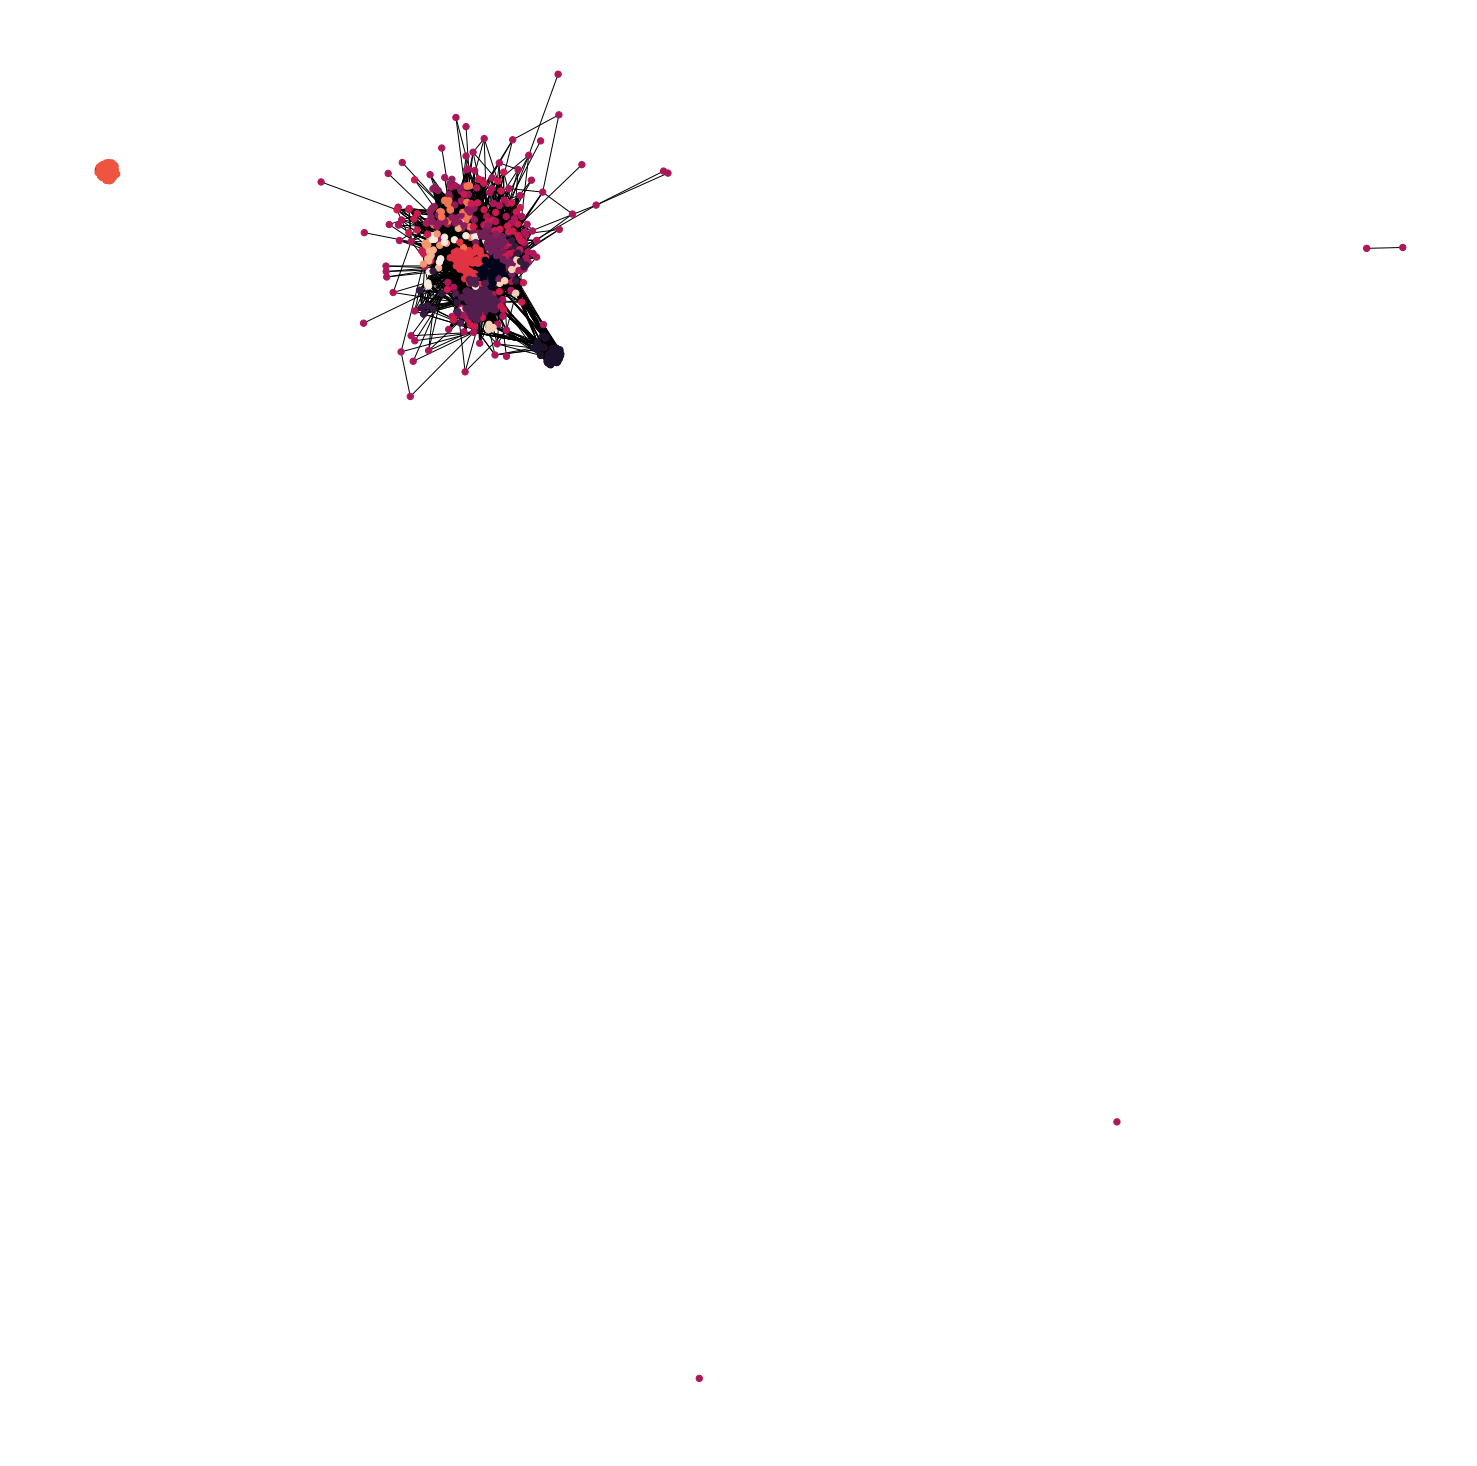

In [25]:
nx.draw_spring(G, node_size=40, 
               node_color=embedding_2d['labels'])

# connect records by subject _and_ hierarchy

In [46]:
alt_ref_no = 'GC'

codes_as_str = sorted(df['AltRefNo'][df['AltRefNo']
                                     .str.startswith(alt_ref_no)
                                     .fillna(False)]
                      .tolist())

In [47]:
codes = {code: re.split('/|\.', code.strip())
         for code in codes_as_str}

In [26]:
adjacency_tree = pd.DataFrame(data=0,
                              index=codes_as_str,
                              columns=codes_as_str)

In [ ]:
for parent_str, parent_list in tqdm(codes.items()):
    for child_str, child_list in codes.items():
        if child_list == parent_list + [child_list[-1]]:
            adjacency_tree[parent_str][child_str] = 1

In [ ]:
ack = adjacency_tree.add(adjacency, fill_value=0).fillna(0)

In [ ]:
orphans = [subject for subject in ack.index.values
           if ack[subject].sum() == ack[subject][subject]]

ack = (ack
       .drop(orphans, axis=0)
       .drop(orphans, axis=1))

In [ ]:
ack.shape

In [ ]:
G = nx.from_pandas_adjacency(ack)

In [ ]:
nx.draw_spring(G, node_size=40)

In [ ]:
embedding_2d = pd.DataFrame(UMAP(n_components=2)
                            .fit_transform(ack))

In [ ]:
n_clusters = 15

embedding_2d['labels'] = (AgglomerativeClustering(n_clusters)
                          .fit_predict(embedding_2d.values))

In [ ]:
nx.draw_spring(G, node_size=40, 
               node_color=embedding_2d['labels'])

In [48]:
(set(map(str.strip, np.array(codes_as_str).astype(str))) & 
 set(map(str.strip, np.array(indicies).astype(str))))

{'GC/2',
 'GC/20',
 'GC/200',
 'GC/201',
 'GC/202',
 'GC/203',
 'GC/205',
 'GC/207',
 'GC/208',
 'GC/209',
 'GC/21',
 'GC/210',
 'GC/211',
 'GC/213',
 'GC/214',
 'GC/215',
 'GC/216',
 'GC/217',
 'GC/218',
 'GC/219',
 'GC/22',
 'GC/220',
 'GC/221',
 'GC/222',
 'GC/223',
 'GC/224',
 'GC/226',
 'GC/227',
 'GC/228',
 'GC/23',
 'GC/231',
 'GC/232',
 'GC/233',
 'GC/236',
 'GC/237',
 'GC/238',
 'GC/239',
 'GC/24',
 'GC/240',
 'GC/241',
 'GC/244',
 'GC/248',
 'GC/249',
 'GC/25',
 'GC/250',
 'GC/251',
 'GC/252',
 'GC/253/A/1',
 'GC/253/A/10',
 'GC/253/A/11',
 'GC/253/A/12',
 'GC/253/A/13',
 'GC/253/A/14',
 'GC/253/A/15',
 'GC/253/A/17',
 'GC/253/A/18',
 'GC/253/A/19',
 'GC/253/A/2',
 'GC/253/A/20',
 'GC/253/A/21',
 'GC/253/A/22',
 'GC/253/A/23',
 'GC/253/A/24',
 'GC/253/A/25',
 'GC/253/A/26',
 'GC/253/A/27',
 'GC/253/A/28',
 'GC/253/A/29',
 'GC/253/A/30',
 'GC/253/A/31',
 'GC/253/A/32',
 'GC/253/A/33',
 'GC/253/A/34',
 'GC/253/A/35',
 'GC/253/A/36',
 'GC/253/A/37',
 'GC/253/A/38',
 'GC/253/A/39